# OSKM States

Colour cells by combination of OKSM expressed in the cells.

Inputs:
1. Seurat RNA object

In [15]:
library(Seurat)
library(ggplot2)

## Load Inputs
### Seurat Object

In [4]:
rna = readRDS("../../analysis/20200828_RNA_Seurat/sessions/20200913_n27632/seurat.rds")
rna$tech = "rna"

## Plotting

In [5]:
oskm_expr = as.matrix(rna@assays$RNA[c("POU5F1", "SOX2", "KLF4", "MYC")])
head(oskm_expr)

,AAACCCAAGAGTGACC-1,AAACCCAAGTGCCAGA-1,AAACCCACACCATTCC-1,AAACCCACACGCGTCA-1,AAACCCAGTCCATAGT-1,AAACCCAGTTATTCTC-1,AAACCCAGTTGTAGCT-1,AAACCCATCAGACATC-1,AAACCCATCCGTAGGC-1,AAACCCATCGTTAGAC-1,⋯,TTTGTTGCAACCACAT-8,TTTGTTGCAGCGTGCT-8,TTTGTTGCAGGACTTT-8,TTTGTTGGTACCTGTA-8,TTTGTTGGTCAAGCCC-8,TTTGTTGGTCCTGGTG-8,TTTGTTGGTCGTTATG-8,TTTGTTGGTCTGTCAA-8,TTTGTTGTCCCTGGTT-8,TTTGTTGTCGTCTACC-8
POU5F1,0.0000000,0.000000,0.0000000,0.0000000,0,0.0000000,0.0000000,0.0000000,0,0,⋯,2.4499997,2.7512612,1.8937520,1.789098,2.903551,2.8492077,3.0446201,0,2.7682245,2.537593
SOX2,0.0000000,0.000000,0.0000000,0.0000000,0,0.0000000,0.0000000,0.0000000,0,0,⋯,1.3249977,0.8368753,0.5912925,0.000000,0.000000,0.9980779,0.9316204,0,0.0000000,1.465184
KLF4,0.5902506,0.000000,0.5671873,0.8148389,0,0.0000000,0.0000000,0.0000000,0,0,⋯,0.3786849,0.5796897,0.5912925,1.096483,0.000000,0.0000000,1.2709861,0,0.0000000,0.000000
MYC,0.0000000,1.028412,0.5671873,0.0000000,0,0.5729634,0.5869346,0.6510742,0,0,⋯,1.9437243,1.2108847,0.9603624,2.992697,1.385807,1.2724516,1.4054200,0,0.4401724,0.000000


In [6]:
oskm_bin = matrix(0, nrow(oskm_expr), ncol(oskm_expr))
rownames(oskm_bin) = rownames(oskm_expr)

for (f in rownames(oskm_expr)) {
#     oskm_bin[f, ] = oskm_expr[f, ] > quantile(rna@assays$RNA@data[f, rna$sample=="D0"], .99)
    oskm_bin[f, ] = oskm_expr[f, ] > quantile(rna@assays$RNA@data[f,], .5)
}

In [7]:
states = matrix(0, 1, ncol(oskm_expr))

for (i in seq(nrow(oskm_bin))) {
    states[1,] = states[1,] + (2**(i-1))*oskm_bin[i, ]
}

In [8]:
factors = c("O", "S", "K", "M")
state_names = rep("", 15)

for (i in seq(4)) {
    for (j in seq(15)) {
        if ( (j%/%2**(i-1)) %% 2 == 1) {
            state_names[j] = paste(state_names[j], factors[i], sep='')
        }
    }
}

state_names = c("NONE", state_names)
state_names

[1] "NONE" "O"    "S"    "OS"   "K"    "OK"   "SK"   "OSK"  "M"    "OM"  
[11] "SM"   "OSM"  "KM"   "OKM"  "SKM"  "OSKM"

In [9]:
table(states[1,])


    0     1     2     3     4     5     6     7     8     9    10    11    12 
17521  1345  1044  2282  2854   818   755  3066  2703   946  1150  2694  2237 
   13    14    15 
 1261  1421 17272 

In [10]:
state_to_color = data.frame(i=seq(1,16),
                           s=state_names,
                           c=c("black", # NONE
                               "darkred", #O
                               "darkblue", #S
                               "chartreuse3", #OS
                               "darkorange4", #K
                               "darkorange3", # OK
                               "coral", #SK
                               "cyan4", #OSK
                               "darkgreen", #M
                               "brown1", #OM
                               "blue2", #SM
                               "darkorchid", #OSM
                               "darkorange2", #KM
                               "darkorange", #OKM
                               "darksalmon", #SKM
                               "deepskyblue") #OSKM
                           )

state_to_color

i,s,c
<int>,<fct>,<fct>
1,NONE,black
2,O,darkred
3,S,darkblue
4,OS,chartreuse3
5,K,darkorange4
6,OK,darkorange3
7,SK,coral
8,OSK,cyan4
9,M,darkgreen


In [12]:
plot_dimred <- function(x, y, col, dimred="UMAP", subset=NULL, sz=0.5) {
    plot_df <- data.frame(x=x, y=y,
                 cluster=col)
    plot_df = plot_df[sample(dim(plot_df)[1]), ]
    
    if (!is.null(subset)) {
        plot_df = plot_df[plot_df$cluster==subset, ]
    }
    
    ggplot(plot_df) +
    geom_point(aes(x=x, y=y, color=cluster), stroke=0, size=sz) +
    theme_classic() +
    xlab(sprintf("%s 1", dimred)) + ylab(sprintf("%s 2", dimred)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    guides(colour = guide_legend(title="Day",
         override.aes = list(shape=16, alpha=1, size=4)))
}

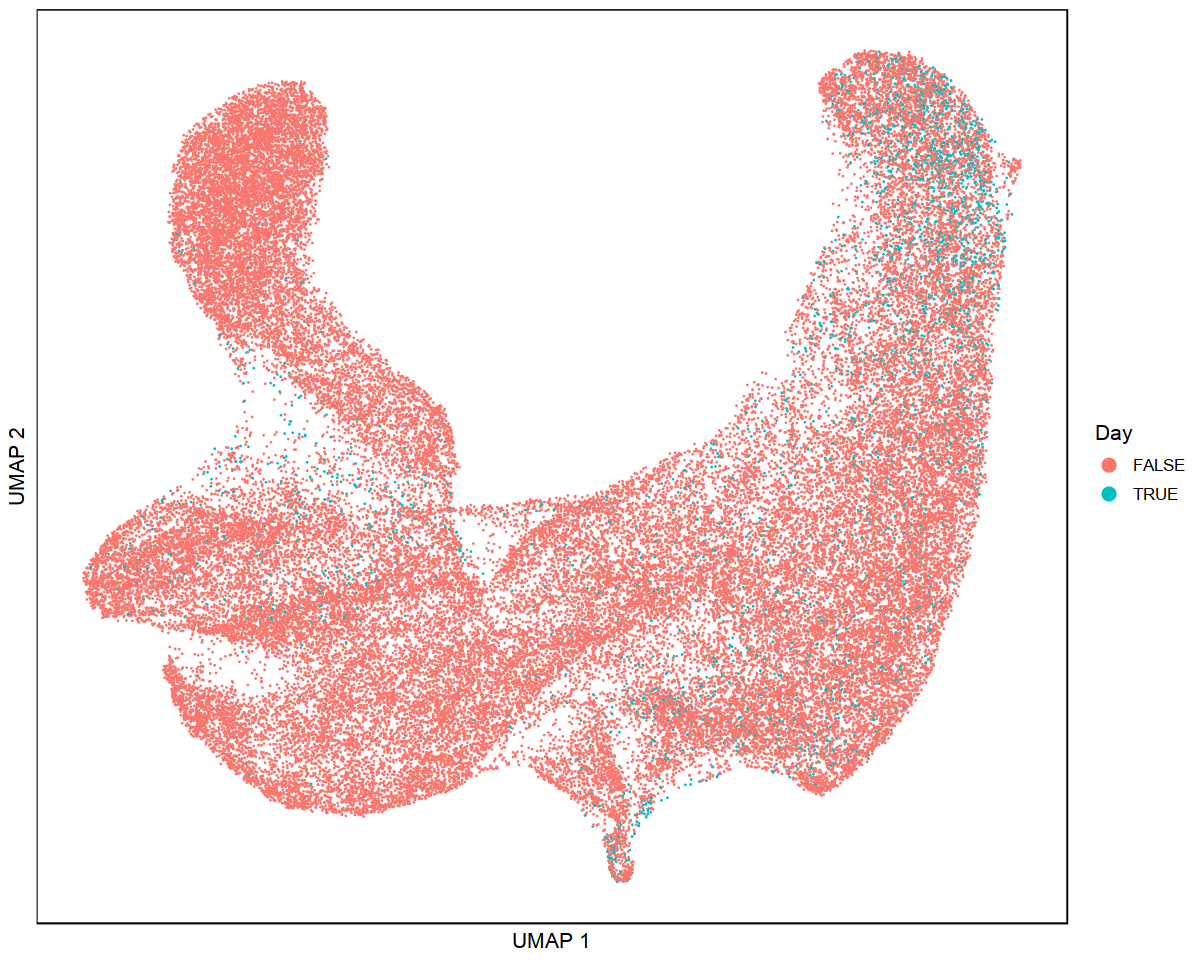

In [16]:
options(repr.plot.width = 10, repr.plot.height = 8)

plot_dimred(data.frame(Embeddings(rna, reduction='umap'))$UMAP_1,
            data.frame(Embeddings(rna, reduction='umap'))$UMAP_2,
            factor(state_names[as.vector(states+1)])=="OSK")

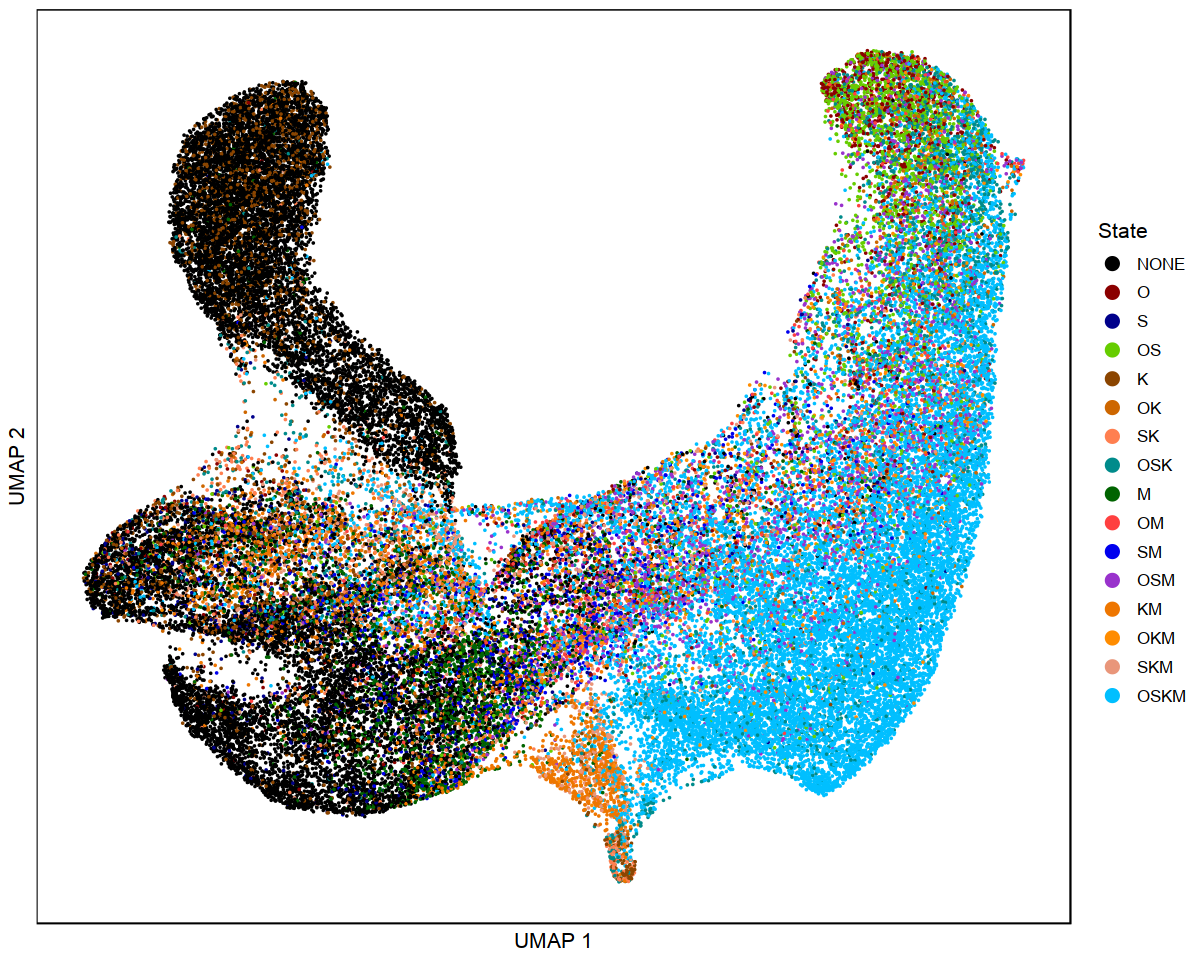

In [17]:
options(repr.plot.width = 10, repr.plot.height = 8)

plot_dimred(data.frame(Embeddings(rna, reduction='umap'))$UMAP_1,
            data.frame(Embeddings(rna, reduction='umap'))$UMAP_2,
            factor(state_names[as.vector(states+1)], levels=state_names), 
           sz=.75) + scale_color_manual(values=as.character(state_to_color$c)) +
guides(color=guide_legend(title="State",
                         override.aes = list(shape=16, alpha=1, size=4)))

---

In [18]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.0 Seurat_3.1.5 

loaded via a namespace (and not attached):
 [1] httr_1.4.1          tidyr_1.1.2         jsonlite_1.6.1     
 [4] viridisLite_0.3.0   splines_3.6.3       lsei_1.2-0         
 [7] leiden_0.3.3        ggrepel_0.8.2       globals_0.12.5     
[10] pillar_1.4.6        lat